In [1]:
# imports
import os
from PIL import Image,ImageTk
import tkinter as tk
from random import shuffle
import matplotlib.pyplot as plt
import numpy as np
from keras.models import Model
from keras.layers import Conv2D, Input, BatchNormalization, Flatten, Dense, UpSampling2D, Lambda, MaxPooling2D, Reshape, LeakyReLU
from tensorflow.keras import backend as K
from tensorflow.keras.losses import mse
import tensorflow as tf
# get code to run on GPU instead of CPU
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

Using TensorFlow backend.


Num GPUs Available:  1


In [5]:
# function to load a random subset of images into memory
mat_shape = (64,64,3)

def get_data(num=5000, mat_shape = mat_shape):

    # get filenames of sofa images
    filenames_sofa = os.listdir(r"anime_faces")
    shuffle(filenames_sofa)
    filenames_sofa = filenames_sofa[0:num]
    
    # load all files into a numpy array
    imgs_lst = []

    for i, filename in enumerate(filenames_sofa):
        # load image
        try:
            img = Image.open(r"anime_faces\\" + filename)
            if (img.size[0] * img.size[1]) > (64*64):
                # scale to 50 X 50
                img = img.resize((mat_shape[0], mat_shape[1]))
                # convert to numpy array
                img = np.asarray(img) / 255
                # add to list
                imgs_lst.append(img)
                #imgs_lst.append(np.fliplr)
        except:
            continue
            
    # convert list of images to nupy array
    imgs = np.zeros((len(imgs_lst), mat_shape[0], mat_shape[1], mat_shape[2]))
    for i, img in enumerate(imgs_lst):
        try:
            imgs[i,:,:,:] = img
        except:
            pass
    # empty list of images to clear memory
    imgs_lst = []
    
    print(imgs.shape)
    return imgs

imgs = get_data(50000)

(44552, 64, 64, 3)


In [3]:
# define sampling layer 
def sampling(args):
    """using the reparameterization trick to sample the latent vector. using log(var) instead of var for
    numerical stabilllity"""
    
    # unpack arguments
    z_mean, z_log_var = args
    # get dimnations of data
    n_batch, dim = K.shape(z_mean)[0], K.shape(z_mean)[1]
    # sample from standard normal
    epsilon = K.random_normal(shape=(n_batch, dim))
    # reparameterization trick
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

In [6]:
n_latent = 300

# define encoder
def build_encoder():
    inputs = Input(shape=(mat_shape[0],mat_shape[0],3))
    x = inputs
    filters = [60,240,360,480] 
    for filter_ in filters: 
        x = Conv2D(filter_, kernel_size=(3,3), strides=1, padding='same')(x)
        x = BatchNormalization()(x)
        x = LeakyReLU()(x)
        x = MaxPooling2D()(x)
    x = Flatten()(x)
    x = Dense(n_latent*2, activation='relu')(x)
    x_m = Dense(n_latent, activation='relu')(x)
    x_s = Dense(n_latent, activation='relu')(x)
    means = Dense(n_latent)(x_m) 
    log_sigmas = Dense(n_latent)(x_s)
    latent = Lambda(sampling, name='sample')([means, log_sigmas])
    
    encoder = Model(inputs,[latent, means, log_sigmas])
    
    return encoder

# define decoder
def build_decoder():
    inputs = Input(shape=(n_latent,))
    x = inputs
    x = Dense(n_latent*2, activation='relu')(x)
    n = 4
    x = Dense(n*n*560)(x)
    x = Reshape((n, n, 560))(x)
    filters = [480, 360, 240, 60]
    for filter_ in filters:
        x = UpSampling2D()(x)
        x = Conv2D(filter_, (3,3), padding='same')(x)
        x = BatchNormalization()(x)
        x = LeakyReLU()(x)
    output = Conv2D(3, kernel_size=1, strides=1, padding='same', activation='sigmoid')(x)
    decoder = Model(inputs, output)
    
    return decoder

#define vae
def build_vae(e, d):
    inputs = Input(shape=(mat_shape[0],mat_shape[0],3))
    z = e(inputs)[0]
    means = e(inputs)[1]
    log_sigmas = e(inputs)[2]
    outputs = d(z)
    vae = Model(inputs, outputs)
    mse_loss = mse(K.flatten(inputs), K.flatten(outputs))
    kl_loss = 1 + log_sigmas - K.square(means) - K.exp(log_sigmas)
    kl_loss = K.sum(kl_loss, axis=-1)
    kl_loss *= -0.5
    loss = K.mean(mse_loss * 10000 + kl_loss)
    vae.add_loss(loss)
    vae.compile(optimizer='adam')
    
    vae.add_metric(kl_loss, name='kl_loss')
    vae.add_metric(mse_loss, name='mse_loss') 
    return vae, loss, mse_loss,kl_loss

# assemble model
enc = build_encoder()
dec = build_decoder()
v, l,mse_loss,kl_loss = build_vae(enc, dec)

C:\Users\Moran\miniconda3\lib\site-packages\keras\engine\training_utils.py:819: UserWarning: Output model_5 missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to model_5.
  'be expecting any data to be passed to {0}.'.format(name))


In [25]:
# train
v.fit(imgs, batch_size=32, epochs=6, verbose=1)

Epoch 1/6
44552/44552 [==============================] - 186s 4ms/step - loss: 255.4756 - kl_loss: 42.0493 - mse_loss: 0.0213
Epoch 2/6
44552/44552 [==============================] - ETA: 0s - loss: 254.7339 - kl_loss: 42.1078 - mse_loss: 0.021 - 192s 4ms/step - loss: 254.7322 - kl_loss: 42.1079 - mse_loss: 0.0213
Epoch 3/6
44552/44552 [==============================] - 191s 4ms/step - loss: 254.2813 - kl_loss: 42.2564 - mse_loss: 0.0212
Epoch 4/6
44552/44552 [==============================] - 191s 4ms/step - loss: 253.5786 - kl_loss: 42.4536 - mse_loss: 0.0211
Epoch 5/6
21024/44552 [=============>................] - ETA: 1:40 - loss: 253.2572 - kl_loss: 42.5203 - mse_loss: 0.0211

KeyboardInterrupt: 

In [40]:
# build GUI

# create the main window
root = tk.Tk()
root.title('sofa designer')
zoom = 4

# get indices of latent variables with highest variance to use in gui
preds = enc.predict(imgs[0:5000])
std = np.std(preds[0], axis=0)
max_std_inds = std.argsort()[-12:][::-1]
means = np.expand_dims(np.mean(preds[0], axis=0),0)
print(means.shape)

# convert predictions to data format suitable for gui
def clip(arr):
    return (arr / np.max(arr) * 255).astype('uint8')
    
global starting_vec 
print(preds[0].shape)
starting_vec = preds[0][402:403,:]
latent = starting_vec
pred = dec.predict(latent)

# command to convert numpy array to image in gui and place it inside the window
img = Image.fromarray(clip(pred.reshape(mat_shape).astype(float)))
img =  ImageTk.PhotoImage(image=img, master = root)
img = img._PhotoImage__photo.zoom(zoom)
panel = tk.Label(root, image=img)
panel.pack(side=tk.LEFT, fill=tk.Y)
#####

power = 0.1 # constant to adjust scaling of latent variable

# add scrollbars
def create_img1(var):
    global sclb1_prev
    value = scrollbar1.get()
    # change value of latent vector displayed in a single latent variable
    if value > sclb1_prev:
        starting_vec[0,max_std_inds[0]] += (value - sclb1_prev) * std[max_std_inds[0]] * power
        sclb1_prev = value
    else:
        starting_vec[0,max_std_inds[0]] -= (sclb1_prev - value) * std[max_std_inds[0]] * power
        sclb1_prev = value
    # command to convert numpy array to image in gui and place it inside the window    
    img = Image.fromarray(clip(dec.predict(starting_vec).reshape(mat_shape).astype(float)))
    img =  ImageTk.PhotoImage(image=img, master = root)
    img = img._PhotoImage__photo.zoom(zoom)
    panel.config(image = img)
    panel.image = img

def create_img2(var):
    value = scrollbar2.get()
    global sclb2_prev
    if value > sclb2_prev:
        starting_vec[0,max_std_inds[1]] += (value - sclb2_prev) * std[max_std_inds[1]] * power
        sclb2_prev = value
    else:
        starting_vec[0,max_std_inds[1]] -= (sclb2_prev - value) * std[max_std_inds[1]] * power
        sclb2_prev = value
    img = Image.fromarray(clip(dec.predict(starting_vec).reshape(mat_shape).astype(float)))
    img =  ImageTk.PhotoImage(image=img, master = root)
    img = img._PhotoImage__photo.zoom(zoom)
    panel.config(image = img)
    panel.image = img    
    
def create_img3(var):
    value = scrollbar3.get()
    global sclb3_prev
    if value > sclb3_prev:
        starting_vec[0,max_std_inds[2]] += (value - sclb3_prev) * std[max_std_inds[2]] * power
        sclb3_prev = value
    else:
        starting_vec[0,max_std_inds[2]] -= (sclb3_prev - value) * std[max_std_inds[2]] * power
        sclb3_prev = value
    img = Image.fromarray(clip(dec.predict(starting_vec).reshape(mat_shape).astype(float)))
    img =  ImageTk.PhotoImage(image=img, master = root)
    img = img._PhotoImage__photo.zoom(zoom)
    panel.config(image = img)
    panel.image = img
    
def create_img4(var):
    value = scrollbar4.get()
    global sclb4_prev
    if value > sclb4_prev:
        starting_vec[0,max_std_inds[3]] += (value - sclb4_prev) * std[max_std_inds[3]] * power
        sclb4_prev = value
    else:
        starting_vec[0,max_std_inds[3]] -= (sclb4_prev - value) * std[max_std_inds[3]] * power
        sclb4_prev = value
    img = Image.fromarray(clip(dec.predict(starting_vec).reshape(mat_shape).astype(float)))
    img =  ImageTk.PhotoImage(image=img, master = root)
    img = img._PhotoImage__photo.zoom(zoom)
    panel.config(image = img)
    panel.image = img    

def create_img5(var):
    value = scrollbar5.get()
    global sclb5_prev
    if value > sclb5_prev:
        starting_vec[0,max_std_inds[4]] += (value - sclb5_prev) * std[max_std_inds[4]] * power
        sclb5_prev = value
    else:
        starting_vec[0,max_std_inds[4]] -= (sclb5_prev - value) * std[max_std_inds[4]] * power
        sclb5_prev = value
    img = Image.fromarray(clip(dec.predict(starting_vec).reshape(mat_shape).astype(float)))
    img =  ImageTk.PhotoImage(image=img, master = root)
    img = img._PhotoImage__photo.zoom(zoom)
    panel.config(image = img)
    panel.image = img 
    
def create_img6(var):
    value = scrollbar6.get()
    global sclb6_prev
    if value > sclb6_prev:
        starting_vec[0,max_std_inds[5]] += (value - sclb6_prev) * std[max_std_inds[5]] * power
        sclb6_prev = value
    else:
        starting_vec[0,max_std_inds[5]] -= (sclb6_prev - value) * std[max_std_inds[5]] * power
        sclb6_prev = value
    img = Image.fromarray(clip(dec.predict(starting_vec).reshape(mat_shape).astype(float)))
    img =  ImageTk.PhotoImage(image=img, master = root)
    img = img._PhotoImage__photo.zoom(zoom)
    panel.config(image = img)
    panel.image = img 
    
def create_img7(var):
    value = scrollbar7.get()
    global sclb7_prev
    if value > sclb7_prev:
        starting_vec[0,max_std_inds[6]] += (value - sclb7_prev) * std[max_std_inds[6]] * power
        sclb7_prev = value
    else:
        starting_vec[0,max_std_inds[6]] -= (sclb7_prev - value) * std[max_std_inds[6]] * power
        sclb7_prev = value
    img = Image.fromarray(clip(dec.predict(starting_vec).reshape(mat_shape).astype(float)))
    img =  ImageTk.PhotoImage(image=img, master = root)
    img = img._PhotoImage__photo.zoom(zoom)
    panel.config(image = img)
    panel.image = img 
    
def create_img8(var):
    value = scrollbar8.get()
    global sclb8_prev
    if value > sclb8_prev:
        starting_vec[0,max_std_inds[7]] += (value - sclb8_prev) * std[max_std_inds[7]] * power
        sclb8_prev = value
    else:
        starting_vec[0,max_std_inds[7]] -= (sclb8_prev - value) * std[max_std_inds[7]] * power
        sclb8_prev = value
    img = Image.fromarray(clip(dec.predict(starting_vec).reshape(mat_shape).astype(float)))
    img =  ImageTk.PhotoImage(image=img, master = root)
    img = img._PhotoImage__photo.zoom(zoom)
    panel.config(image = img)
    panel.image = img 
    
def create_img9(var):
    value = scrollbar9.get()
    global sclb9_prev
    if value > sclb9_prev:
        starting_vec[0,max_std_inds[8]] += (value - sclb9_prev) * std[max_std_inds[8]] * power
        sclb9_prev = value
    else:
        starting_vec[0,max_std_inds[8]] -= (sclb9_prev - value) * std[max_std_inds[8]] * power
        sclb9_prev = value
    img = Image.fromarray(clip(dec.predict(starting_vec).reshape(mat_shape).astype(float)))
    img =  ImageTk.PhotoImage(image=img, master = root)
    img = img._PhotoImage__photo.zoom(zoom)
    panel.config(image = img)
    panel.image = img 
    
def create_img10(var):
    value = scrollbar10.get()
    global sclb10_prev
    if value > sclb10_prev:
        starting_vec[0,max_std_inds[9]] += (value - sclb10_prev) * std[max_std_inds[9]] * power
        sclb10_prev = value
    else:
        starting_vec[0,max_std_inds[9]] -= (sclb10_prev - value) * std[max_std_inds[9]] * power
        sclb10_prev = value
    img = Image.fromarray(clip(dec.predict(starting_vec).reshape(mat_shape).astype(float)))
    img =  ImageTk.PhotoImage(image=img, master = root)
    img = img._PhotoImage__photo.zoom(zoom)
    panel.config(image = img)
    panel.image = img
    
def create_img11(var):
    value = scrollbar11.get()
    global sclb11_prev
    if value > sclb11_prev:
        starting_vec[0,max_std_inds[10]] += (value - sclb11_prev) * std[max_std_inds[10]] * power
        sclb11_prev = value
    else:
        starting_vec[0,max_std_inds[10]] -= (sclb11_prev - value) * std[max_std_inds[10]] * power
        sclb11_prev = value
    img = Image.fromarray(clip(dec.predict(starting_vec).reshape(mat_shape).astype(float)))
    img =  ImageTk.PhotoImage(image=img, master = root)
    img = img._PhotoImage__photo.zoom(zoom)
    panel.config(image = img)
    panel.image = img     

def create_img12(var):
    value = scrollbar12.get()
    global sclb12_prev
    if value > sclb12_prev:
        starting_vec[0,max_std_inds[11]] += (value - sclb12_prev) * std[max_std_inds[11]] * power
        sclb12_prev = value
    else:
        starting_vec[0,max_std_inds[11]] -= (sclb12_prev - value) * std[max_std_inds[11]] * power
        sclb12_prev = value
    img = Image.fromarray(clip(dec.predict(starting_vec).reshape(mat_shape).astype(float)))
    img =  ImageTk.PhotoImage(image=img, master = root)
    img = img._PhotoImage__photo.zoom(zoom)
    panel.config(image = img)
    panel.image = img  

# initial values for scrollbar
global sclb1_prev
sclb1_prev = 0
global sclb2_prev
sclb2_prev = 0
global sclb3_prev
sclb3_prev = 0
global sclb4_prev
sclb4_prev = 0
global sclb5_prev
sclb5_prev = 0
global sclb6_prev
sclb6_prev = 0
global sclb7_prev
sclb7_prev = 0
global sclb8_prev
sclb8_prev = 0
global sclb9_prev
sclb9_prev = 0
global sclb10_prev
sclb10_prev = 0
global sclb11_prev
sclb11_prev = 0
global sclb12_prev
sclb12_prev = 0

# place scrollbars
limit = 50
scrollbar1 = tk.Scale(root, from_=-1*limit, to=limit, command=create_img1, length=530)
scrollbar1.pack(side=tk.RIGHT)

scrollbar2 = tk.Scale(root, from_=-1*limit, to=limit, command=create_img2, length=530)
scrollbar2.pack(side=tk.RIGHT)

scrollbar3 = tk.Scale(root, from_=-1*limit, to=limit, command=create_img3, length=530)
scrollbar3.pack(side=tk.RIGHT)

scrollbar4 = tk.Scale(root, from_=-1*limit, to=limit, command=create_img4, length=530)
scrollbar4.pack(side=tk.RIGHT)

scrollbar5 = tk.Scale(root, from_=-1*limit, to=limit, command=create_img5, length=530)
scrollbar5.pack(side=tk.RIGHT)

scrollbar6 = tk.Scale(root, from_=-1*limit, to=limit, command=create_img6, length=530)
scrollbar6.pack(side=tk.RIGHT)

scrollbar7 = tk.Scale(root, from_=-1*limit, to=limit, command=create_img7, length=530)
scrollbar7.pack(side=tk.RIGHT)

scrollbar8 = tk.Scale(root, from_=-1*limit, to=limit, command=create_img8, length=530)
scrollbar8.pack(side=tk.RIGHT)

scrollbar9 = tk.Scale(root, from_=-1*limit, to=limit, command=create_img9, length=530)
scrollbar9.pack(side=tk.RIGHT)

scrollbar10 = tk.Scale(root, from_=-1*limit, to=limit, command=create_img10, length=530)
scrollbar10.pack(side=tk.RIGHT)

scrollbar11 = tk.Scale(root, from_=-1*limit, to=limit, command=create_img11, length=530)
scrollbar11.pack(side=tk.RIGHT)

scrollbar12 = tk.Scale(root, from_=-1*limit, to=limit, command=create_img12, length=530)
scrollbar12.pack(side=tk.RIGHT)

# intiate the program
root.mainloop()

(1, 300)
(5000, 300)


[16403 20980 24746 14588]


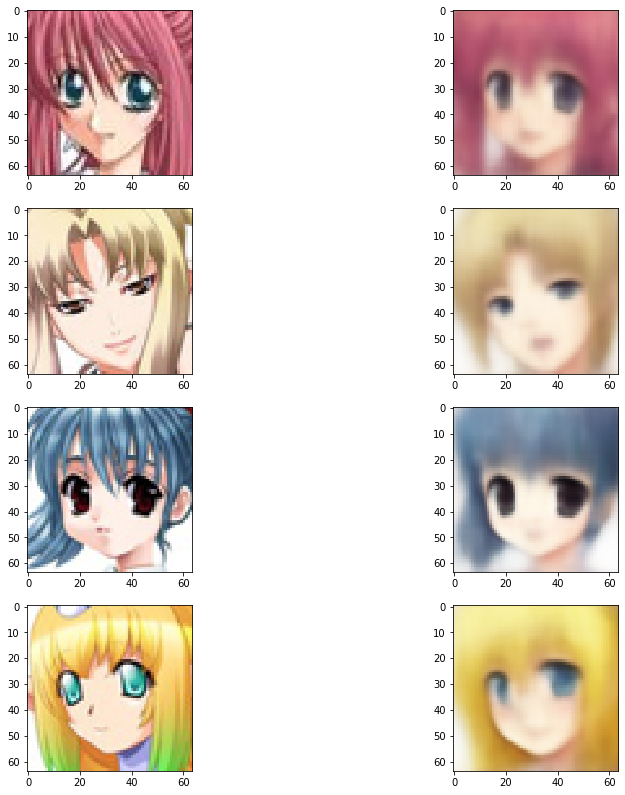

In [24]:
# print examples
inds = np.random.randint(0,imgs.shape[0],4)
original = imgs[inds,:,:,:]
results = v.predict(original)
print(inds)
f, a = plt.subplots(4, 2, figsize=(14, 14))
a[0,0].imshow(original[0,:].reshape(mat_shape).astype(float))
a[1,0].imshow(original[1,:].reshape(mat_shape).astype(float))
a[2,0].imshow(original[2,:].reshape(mat_shape).astype(float))
a[3,0].imshow(original[3,:].reshape(mat_shape).astype(float))
a[0,1].imshow(results[0,:].reshape(mat_shape).astype(float))
a[1,1].imshow(results[1,:].reshape(mat_shape).astype(float))
a[2,1].imshow(results[2,:].reshape(mat_shape).astype(float))
a[3,1].imshow(results[3,:].reshape(mat_shape).astype(float));

In [200]:
v.save('vae_anime_faces.hdf5')
enc.save('enc_')

(array([ 67., 208.,  10.,   0.,   4.,   4.,   5.,   0.,   0.,   2.]),
 array([0.95352125, 0.9846598 , 1.0157983 , 1.0469369 , 1.0780754 ,
        1.1092138 , 1.1403524 , 1.1714909 , 1.2026294 , 1.233768  ,
        1.2649065 ], dtype=float32),
 <a list of 10 Patch objects>)

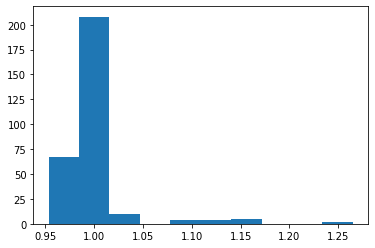

In [122]:
plt.hist(std)

In [ ]:
preds = enc.predict(imgs[0:5000])

(array([  35.,  232.,  895., 1803., 1090.,  594.,  275.,   43.,   21.,
          12.]),
 array([-0.10440994, -0.08221065, -0.06001134, -0.03781205, -0.01561275,
         0.00658655,  0.02878585,  0.05098515,  0.07318445,  0.09538375,
         0.11758304], dtype=float32),
 <a list of 10 Patch objects>)

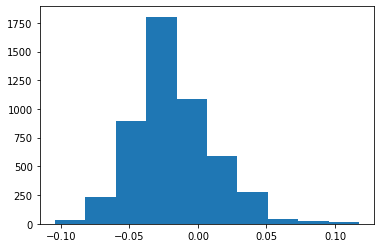

In [81]:
plt.hist(preds[1][:,0])

(array([7.370e+02, 2.107e+03, 1.654e+03, 3.900e+02, 8.300e+01, 4.000e+00,
        1.000e+01, 1.100e+01, 2.000e+00, 2.000e+00]),
 array([-0.10832715, -0.07945364, -0.05058013, -0.02170661,  0.0071669 ,
         0.03604041,  0.06491392,  0.09378743,  0.12266095,  0.15153445,
         0.18040797], dtype=float32),
 <a list of 10 Patch objects>)

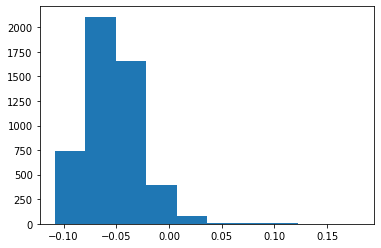

In [87]:
plt.hist(preds[2][:,6])

In [42]:
np.log(0.0006)

-7.418580902748128